# Data Analytics Project- Traffic Accident Duration Prediction Models

In [ ]:
from pyspark.sql import SparkSession

# Initialize a SparkSession
spark = SparkSession.builder.enableHiveSupport().getOrCreate()

# Read the Hive tables stored in Databricks into DataFrames
# because of the file size, the data was splitted into different files
table_name0 = "hive_metastore.default.chunk_0"
df_0 = spark.sql(f"SELECT * FROM {table_name0}")

table_name1 = "hive_metastore.default.chunk_1"
df_1 = spark.sql(f"SELECT * FROM {table_name1}")

table_name2 = "hive_metastore.default.chunk_2"
df_2 = spark.sql(f"SELECT * FROM {table_name2}")

table_name3 = "hive_metastore.default.chunk_3"
df_3 = spark.sql(f"SELECT * FROM {table_name3}")

table_name4 = "hive_metastore.default.chunk_4"
df_4 = spark.sql(f"SELECT * FROM {table_name4}")

table_name5 = "hive_metastore.default.chunk_5"
df_5 = spark.sql(f"SELECT * FROM {table_name5}")

table_name6 = "hive_metastore.default.chunk_6"
df_6 = spark.sql(f"SELECT * FROM {table_name6}")

table_name7 = "hive_metastore.default.chunk_7"
df_7 = spark.sql(f"SELECT * FROM {table_name7}")

# Append the DataFrames together
df = df_0.union(df_1).union(df_2).union(df_3).union(df_4).union(df_5).union(df_6).union(df_7)

In [ ]:
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

In [ ]:
seed=12

In [ ]:
#to check how many rows and columns the dataset contains
num_rows = df.count()
print(f"The data frame contains {num_rows} number of rows.")
num_cols = len(df.columns)
print(f"The data frame contains {num_cols} number of columns.")


# Preprocessing

In [ ]:
# Initially I chose 19 features to analyze and excluded the features that have too many null values
# (e.g. 'End_Lat' and 'End_Lng' have almost 50% of the values with null values)
selected_df = df.select(
 'Severity',
 'Start_Time',
 'End_Time',
 'Start_Lat',
 'Start_Lng',
 'Distance(mi)',
 'Street',
 'City',
 'County',
 'State',
 'Weather_Timestamp',
 'Temperature(F)',
 'Wind_Chill(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Sunrise_Sunset')


#1. Feature Creation

In [ ]:
# calculate the duration in minutes and create a new column with that feature
selected_df = selected_df.withColumn("Duration", ((unix_timestamp("End_Time") - unix_timestamp("Start_Time"))/60))

# Show the results
selected_df.select("Start_Time", "End_Time", "Duration").show()


+-------------------+-------------------+--------+
|         Start_Time|           End_Time|Duration|
+-------------------+-------------------+--------+
|2016-02-08 05:46:00|2016-02-08 11:00:00|   314.0|
|2016-02-08 06:07:59|2016-02-08 06:37:59|    30.0|
|2016-02-08 06:49:27|2016-02-08 07:19:27|    30.0|
|2016-02-08 07:23:34|2016-02-08 07:53:34|    30.0|
|2016-02-08 07:39:07|2016-02-08 08:09:07|    30.0|
|2016-02-08 07:44:26|2016-02-08 08:14:26|    30.0|
|2016-02-08 07:59:35|2016-02-08 08:29:35|    30.0|
|2016-02-08 07:59:58|2016-02-08 08:29:58|    30.0|
|2016-02-08 08:00:40|2016-02-08 08:30:40|    30.0|
|2016-02-08 08:10:04|2016-02-08 08:40:04|    30.0|
|2016-02-08 08:14:42|2016-02-08 08:44:42|    30.0|
|2016-02-08 08:21:27|2016-02-08 08:51:27|    30.0|
|2016-02-08 08:36:34|2016-02-08 09:06:34|    30.0|
|2016-02-08 08:37:07|2016-02-08 09:07:07|    30.0|
|2016-02-08 08:39:43|2016-02-08 09:09:43|    30.0|
|2016-02-08 08:43:20|2016-02-08 09:13:20|    30.0|
|2016-02-08 08:53:17|2016-02-08

# 2. Handling outliers using interquartile range

In [ ]:
def IQR_method(df_name, col_name):
    # to find outliers using IQR methods
    quartiles = df_name.approxQuantile(col_name, [0.25, 0.75], 0.01)
    
    Q1 = quartiles[0]
    print("Q1: ", Q1)
    
    Q3 = quartiles[1]
    print("Q3: ", Q3)
    
    IQR = Q3 - Q1
    
    lowerBound = Q1 - 1.5 * IQR
    print("lower bound: ", lowerBound)
    
    upperBound = Q3 + 1.5 * IQR
    print("upper bound: ", upperBound)

    outliers_df = df_name.filter((col(col_name) < lowerBound) | (col(col_name) > upperBound))
    print("number of outliers: ", outliers_df.count())
    
    print("percentage of outliers from the dataset: ", (outliers_df.count()/df_name.count()) * 100)

    #removing the outliers from the dataset
    filtered_df = df_name.filter((col(col_name) > lowerBound) & (col(col_name) < upperBound))
    print("number of rows after removing outliers: ", filtered_df.count())

    return filtered_df

In [ ]:
selected_df.select("Duration").summary().show()

In [ ]:
#remove outliers for "Duration" column which will be our target variable
removed_duration_df = IQR_method(selected_df, "Duration")


q1:  31.483333333333334
q3:  124.76666666666667
lower bound:  -108.44166666666668
upper bound:  264.69166666666666
number of outliers:  733470
percentage of outliers from the dataset:  9.49058756579957
number of rows after removing outliers:  6994924


In [ ]:
removed_duration_df.select("Distance(mi)").summary().show()

In [ ]:
df.select("Distance(mi)").toPandas().hist(bins=50)

In [ ]:
#remove outliers for "Distance(mi)" because it is highly skewed to the left (less than 1 mile)
outliers_removed_df = IQR_method(removed_duration_df, "Distance(mi)")


q1:  0.0
q3:  0.3670000000000001
lower bound:  -0.5505000000000002
upper bound:  0.9175000000000003
number of outliers:  1003836
percentage of outliers from the dataset:  14.350920753392032
number of rows after removing outliers:  5991088


In [ ]:
outliers_removed_df.select('Visibility(mi)').summary().show()

#keep visibility that are less than 20 only because the majority is skewed to the left (less than 10 miles)
removed_visibil_df = outliers_removed_df.filter(col('Visibility(mi)') < 20)

print("number of rows after removing outliers: ", removed_visibil_df.count())

+-------+-----------------+
|summary|   Visibility(mi)|
+-------+-----------------+
|  count|          5862493|
|   mean|9.119237012308608|
| stddev|2.642281516788764|
|    min|              0.0|
|    25%|             10.0|
|    50%|             10.0|
|    75%|             10.0|
|    max|            140.0|
+-------+-----------------+

number of rows after removing outliers:  5851403


In [ ]:
#count nulls in each column and display the results
null_counts = removed_visibil_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in removed_visibil_df.columns])
null_counts.show(truncate=False)


+--------+----------+--------+---------+---------+------------+------+----+------+-----+-----------------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+--------------+--------+
|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|Distance(mi)|Street|City|County|State|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Sunrise_Sunset|Duration|
+--------+----------+--------+---------+---------+------------+------+----+------+-----+-----------------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+--------------+--------+
|0       |0         |0       |0        |0        |0           |8406  |144 |0     |0    |0                |19216         |1458611      |26794      |6709        |0             |337200         |1626740          |12816         |0       |
+--------+----------+--------+---------+---------+------------+-

# 3. Handling missing data

In [ ]:
# handling missing values in columns
from pyspark.sql.window import Window
#set the window spec to be in the timely order based on the weather timestamp recording the time when the weather data was observed
window_spec = Window.orderBy('Weather_Timestamp')

def handle_missing_values(col_name, df_name, window_spec):

    column = df_name[col_name]
    #calculate the average value of the column
    avg_value = df_name.select(avg(col_name)).collect()[0][0]

    #when there are missing values, replace the null values according to the following conditions:
    #1) use the previous value from the lag function when it is available
    #2) use the next value from the lead function when it is available
    #3) use the constant of average value from lit function when none of the previous or next values are available
    #otherwise, when it is not null, keep the value as it is
    result_df = df_name.withColumn(col_name, 
                                    when(isnull(column), 
                                        coalesce(lag(column).over(window_spec), 
                                                lead(column).over(window_spec),
                                                lit(avg_value))).otherwise(column))
    
    return result_df
    

In [ ]:
# fill the missing values in 'Temperature(F)'
filtered_temp = handle_missing_values('Temperature(F)', removed_visibil_df, window_spec)


In [ ]:
# as Sunrise_Sunset column contains categorical data (i.e., Day or Night based on Sunrise and Sunset),
# we will use forward filling method to fill missing values by replacing it with previous data.
# if there is a null value, replace with a previous non-null value.
filtered_sun = filtered_temp.withColumn("Sunrise_Sunset", last("Sunrise_Sunset", ignorenulls=True).over(window_spec))


In [ ]:
# Weather_Timestamp was used for window spec but will not be used further, so drop here
#as we did calculate and create Duration column already, End_Time also can be dropped as it will not be used further
selected_cols_df = filtered_sun.drop("Weather_Timestamp", "End_Time")

#check again nulls
null_counts = selected_cols_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in selected_cols_df.columns])
null_counts.show(truncate=False)


+--------+----------+---------+---------+------------+------+----+------+-----+--------------+-------------+-----------+------------+--------------+---------------+-----------------+--------------+--------+
|Severity|Start_Time|Start_Lat|Start_Lng|Distance(mi)|Street|City|County|State|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Sunrise_Sunset|Duration|
+--------+----------+---------+---------+------------+------+----+------+-----+--------------+-------------+-----------+------------+--------------+---------------+-----------------+--------------+--------+
|0       |0         |0        |0        |0           |8406  |144 |0     |0    |0             |1458611      |26794      |6709        |0             |337200         |1626740          |0             |0       |
+--------+----------+---------+---------+------------+------+----+------+-----+--------------+-------------+-----------+------------+--------------+---------------+--------

In [ ]:
# Extract time features from Start_Time
transformed_df = selected_cols_df.withColumn("hour", hour("Start_Time")).withColumn("day_of_week", dayofweek("Start_Time")).withColumn("month", month("Start_Time")).withColumn("year", year("Start_Time")).withColumn("day_of_month", dayofmonth("Start_Time"))

transformed_df = transformed_df.drop("Start_Time")

In [ ]:
# check the number of accidents per year
transformed_df.groupBy("year").count().orderBy("year").show()

In [ ]:
# drop the year 2023 as it contains only the first three months of that year (January through March) which does not 
# provide the full information of that year.
removed_year_df = transformed_df.filter(col("year") < 2023)
removed_year_df.count()

5679766

In [ ]:
# as only 183 rows have null values in column 'City' which won't affect the result, it is decided to simply drop those rows.
removed_city_df = removed_year_df.filter(removed_year_df['City'].isNotNull())

# likewise, drop 'Street' that contains nulls because it is not reasonable to randomly fill them and it is a relatively small proportion of the dataset
removed_street_df = removed_city_df.filter(removed_city_df['Street'].isNotNull())


In [ ]:
removed_street_df.count()

In [ ]:
removed_street_df.printSchema()

# 4. Handling categorical values using StringIndexer

In [ ]:
from pyspark.ml.feature import StringIndexer
string_cols = ['Sunrise_Sunset']
stages = []
for val in string_cols:
    # StringIndexer to index the column
    string_indexer = StringIndexer(inputCol=val, outputCol=f"{val}_indexed")
    stages.append(string_indexer)

pipeline = Pipeline(stages=stages)
model = pipeline.fit(removed_year_df).transform(removed_year_df)

model = model.drop(*string_cols)


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
model.printSchema()

In [ ]:
model.columns

# Correlation Evaluation Using Correlation Heatmap

In [ ]:

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
# Define the features
feature_cols = ['Severity',
'Start_Lat',
 'Start_Lng',
 'Distance(mi)',
 'Temperature(F)',
 'Wind_Chill(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Duration',
 'hour',
 'day_of_week',
 'month',
 'year',
 'day_of_month',
 'Street_indexed',
 'City_indexed',
 'County_indexed',
 'State_indexed',
 'Sunrise_Sunset_indexed']

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip") 
prepared_df = assembler.transform(model)

corr_matrix = Correlation.corr(prepared_df, "features").head()
corr_matrix = corr_matrix[0].toArray()

import pandas as pd
corr_matrix_df = pd.DataFrame(corr_matrix, columns=feature_cols, index=feature_cols)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(corr_matrix_df)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix_df, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

# Based on the result, it shows there are not many features that have a strong correlation with Duration.
# But it only shows the linear relationships so we cannot determine the non-linear relationships.
# Therefore, by considering all results we have observed through EDA, I select "severity, distance, temperature, start_lat,
# start_lng, visibility, sunrise_sunset, hour, day_of_week, month, year" as the independent variables to be used in the predictive models.

# 5. Handling categorical values using one hot encoding

In [ ]:
new_df = model.select('Severity', "Start_Lat", "Start_Lng", 'Distance(mi)', 'Temperature(F)', 'Visibility(mi)', 'Duration', 'Sunrise_Sunset_indexed','hour','day_of_week','month','year')

In [ ]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline

categorical_cols = ['Severity','hour','day_of_week','month','year']
# I treat time-related features as categorical here because they do not have a linear relationship; 
# each day of week, each month, each year are more like categories.
# even using them as numerical values and conducting experiments, it was observed that they perform better when treated as categorical features.
stages = []

for val in categorical_cols:
    encoder = OneHotEncoder(inputCol=val, outputCol=f"{val}_encoded")
    stages.append(encoder)

pipeline = Pipeline(stages=stages)
onehot_df = pipeline.fit(new_df).transform(new_df)

onehot_df = onehot_df.drop(*categorical_cols)



Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

# 6. Standardization of numerical features

In [ ]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

numeric_cols = ["Start_Lat", "Start_Lng", 'Distance(mi)', 'Temperature(F)', 'Visibility(mi)']
assembler = VectorAssembler(inputCols=numeric_cols, outputCol='numeric_features')
scaler = StandardScaler(inputCol='numeric_features', outputCol='scaled_features')

pipeline_numeric = Pipeline(stages=[assembler, scaler])
transformed_df_numeric = pipeline_numeric.fit(onehot_df).transform(onehot_df)





Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
transformed_df_numeric.printSchema()

In [ ]:
transformed_df_numeric.select("scaled_features").show(truncate=False)

In [ ]:
feature_cols = ['scaled_features', 'Sunrise_Sunset_indexed', 'Severity_encoded', 'hour_encoded','day_of_week_encoded','month_encoded','year_encoded']

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
prepared_df = assembler.transform(transformed_df_numeric)

In [ ]:
prepared_df = prepared_df.withColumnRenamed("Duration", "label")


In [ ]:
df_for_regression = prepared_df.select("label", "features")
df_for_regression.show(truncate=False)

+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                     |
+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------+
|30.0 |(2074,[0,1,2,3,4,5,8,16,35,42,2068],[7.934490783552333,-4.798026143657379,0.04770741800144333,2.0364391605230496,4.392841175193907,1.0,1.0,1.0,1.0,1.0,1.0]) |
|30.0 |(2074,[0,1,2,3,4,5,8,16,35,42,2068],[7.762615953421142,-4.867619061242831,0.04770741800144333,1.9343485429770393,4.392841175193907,1.0,1.0,1.0,1.0,1.0,1.0]) |
|30.0 |(2074,[0,1,2,3,4,5,9,17,35,42,2068],[7.89866043439313,-4.8776386424451585,0.04770741800144333,1.8859898294026132,3.9535570576745167,1.0,1.0,1.0,1.0,1.0,1.0])|
|30.

In [ ]:
#after shuffling, extract 10% of df to reduce the time of training
shuffled_df = df_for_regression.orderBy(rand()) 
small_subset = shuffled_df.sample(fraction=0.1, seed=seed) 

sample_train, sample_test = small_subset.randomSplit([0.8, 0.2], seed=seed)

# Training and Testing Models

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="label", predictionCol="prediction")
mse_evaluator = RegressionEvaluator(metricName="mse", labelCol="label", predictionCol="prediction")


#Baseline models

In [ ]:
#basic models using default parameters
dtr = DecisionTreeRegressor(featuresCol='features', labelCol='label').setSeed(seed)
rf = RandomForestRegressor(featuresCol='features', labelCol='label').setSeed(seed)
gbt = GBTRegressor(featuresCol='features', labelCol='label').setSeed(seed)

In [ ]:
#DTR

# Fit the model on the training data
dtr_model = dtr.fit(sample_train)

# Make predictions on the test data
dtr_predictions = dtr_model.transform(sample_test)


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:

dtr_MAE = mae_evaluator.evaluate(dtr_predictions)
print("DTR model MAE result on test data = %g" % dtr_MAE)
 
dtr_RMSE = rmse_evaluator.evaluate(dtr_predictions)
print("DTR model RMSE result on test data = %g" % dtr_RMSE)

DTR model MAE result on test data = 27.6169
DTR model RMSE result on test data = 39.442


In [ ]:
#RF

# Fit the model on the training data
rf_model = rf.fit(sample_train)

# Make predictions on the test data
rf_predictions = rf_model.transform(sample_test)


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Evaluate the RF model
rf_MAE = mae_evaluator.evaluate(rf_predictions)
print("RF model MAE result on test data = %g" % rf_MAE)

rf_RMSE = rmse_evaluator.evaluate(rf_predictions)
print("RF model RMSE result on test data = %g" % rf_RMSE)
 

RF model MAE result on test data = 28.0841
RF model RMSE result on test data = 39.3954


In [ ]:
#GBT

# Fit the model on the training data
gbt_model = gbt.fit(sample_train)

# Make predictions on the test data
gbt_predictions = gbt_model.transform(sample_test)


In [ ]:
# Evaluate the GBT model

gbt_MAE = mae_evaluator.evaluate(gbt_predictions)
print("GBT model MAE result on test data = %g" % gbt_MAE)

gbt_RMSE = rmse_evaluator.evaluate(gbt_predictions)
print("GBT model RMSE result on test data = %g" % gbt_RMSE)
 

# Hyperparameter tuning

In [ ]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
#DTR
dtr_param_grid = ParamGridBuilder().addGrid(dtr.maxDepth, [10, 15]).addGrid(dtr.maxBins, [40, 60]).build()

dtr_tvs = TrainValidationSplit(estimator=dtr,
                              estimatorParamMaps=dtr_param_grid,
                              evaluator=rmse_evaluator,
                              trainRatio=0.8,
                               seed=seed
                              )    
# Fit the model on the training data
dtr_tuned_model = dtr_tvs.fit(sample_train)

# Make predictions on the test data
tuned_dtr_predictions = dtr_tuned_model.transform(sample_test)

# Get the best model
dtr_best_model = dtr_tuned_model.bestModel


In [ ]:
# after running the above code, it was found that MaxDepth=15 and MaxBins=60 gave the best result among the given hyperparameters,
# so it was directly set to those numbers in this code to save the training time

tuned_dtr = dtr.setMaxDepth(15).setMaxBins(60)
# Fit the model on the training data
dtr_tuned_model = tuned_dtr.fit(sample_train)

# Make predictions on the test data
tuned_dtr_predictions = dtr_tuned_model.transform(sample_test)
   

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:

tuned_dtr_MAE = mae_evaluator.evaluate(tuned_dtr_predictions)
print("Best DTR model MAE on test data = %g" % tuned_dtr_MAE)

tuned_dtr_RMSE = rmse_evaluator.evaluate(tuned_dtr_predictions)
print("Best DTR model RMSE on test data = %g" % tuned_dtr_RMSE)

Best DTR model MAE on test data = 23.4732
Best DTR model RMSE on test data = 35.2183


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
#RF

rf_param_grid = ParamGridBuilder().addGrid(rf.maxDepth, [10, 15]).addGrid(rf.maxBins, [40, 60]).build()

rf_tvs = TrainValidationSplit(estimator=rf,
                              estimatorParamMaps=rf_param_grid,
                              evaluator=rmse_evaluator,
                              trainRatio=0.8,
                              seed=seed
                              )    
# Fit the model on the training data

rf_tuned_model = rf_tvs.fit(sample_train)

# Make predictions on the test data
tuned_rf_predictions = rf_tuned_model.transform(sample_test)


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:

tuned_rf_MAE = mae_evaluator.evaluate(tuned_rf_predictions)
print("Best RF model MAE on test data = %g" % tuned_rf_MAE)

tuned_rf_RMSE = rmse_evaluator.evaluate(tuned_rf_predictions)
print("Best RF model RMSE on test data = %g" % tuned_rf_RMSE)


Best RF model MAE on test data = 23.853
Best RF model RMSE on test data = 34.7114


In [ ]:
#GBT

gbt_param_grid = ParamGridBuilder().addGrid(gbt.maxDepth, [10, 15]).addGrid(gbt.maxIter, [20, 30]).build()
gbt_tvs = TrainValidationSplit(estimator=gbt,
                              estimatorParamMaps=gbt_param_grid,
                              evaluator=rmse_evaluator,
                              trainRatio=0.8,
                               seed=seed
                              )    

# Fit the model on the training data
gbt_tuned_model = gbt_tvs.fit(sample_train)

# Make predictions on the test data
gbt_predictions = gbt_tuned_model.transform(sample_test)
    

# Get the best model
gbt_best_model = gbt_tuned_model.bestModel


In [ ]:
# after running the above code, it was found that MaxDepth=15 and MaxIter=30 gave the best result among the given hyperparameters,
# so it was directly set to those numbers in this code to save the training time

tuned_gbt = gbt.setMaxDepth(15).setMaxIter(30)
# Fit the model on the training data
gbt_tuned_model = tuned_gbt.fit(sample_train)

# Make predictions on the test data
tuned_gbt_predictions = gbt_tuned_model.transform(sample_test)
   

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
tuned_gbt_MAE = mae_evaluator.evaluate(tuned_gbt_predictions)
print("Best GBT model MAE on test data = %g" % tuned_gbt_MAE)

tuned_gbt_RMSE = rmse_evaluator.evaluate(tuned_gbt_predictions)
print("Best GBT model RMSE on test data = %g" % tuned_gbt_RMSE)


Best GBT model MAE on test data = 20.86
Best GBT model RMSE on test data = 31.9416


# Result visualization

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_results(model_output, model_name):

    predictions_df = model_output.select("prediction", "label").toPandas()
    # generate random samples because otherwise the scatter plot would be too cluttered
    sampled_result = predictions_df.sample(n=1000)
    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(sampled_result['prediction'], sampled_result['label'], alpha=0.5)

    plt.title(f"{model_name} Scatter Plot of Predicted vs. Actual Values")
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.show()


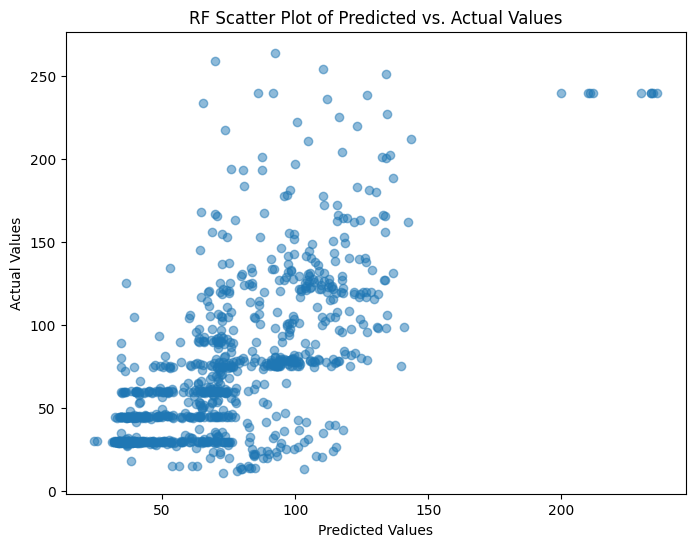

In [ ]:
plot_results(tuned_rf_predictions, 'RF')

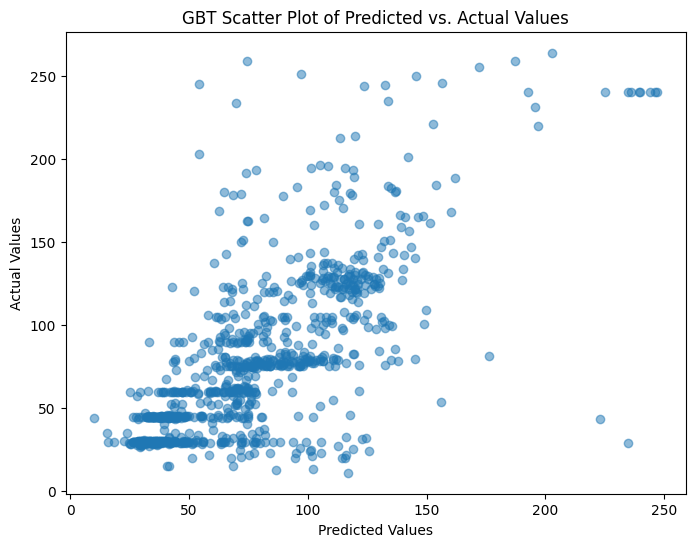

In [ ]:
plot_results(tuned_gbt_predictions, 'GBT')

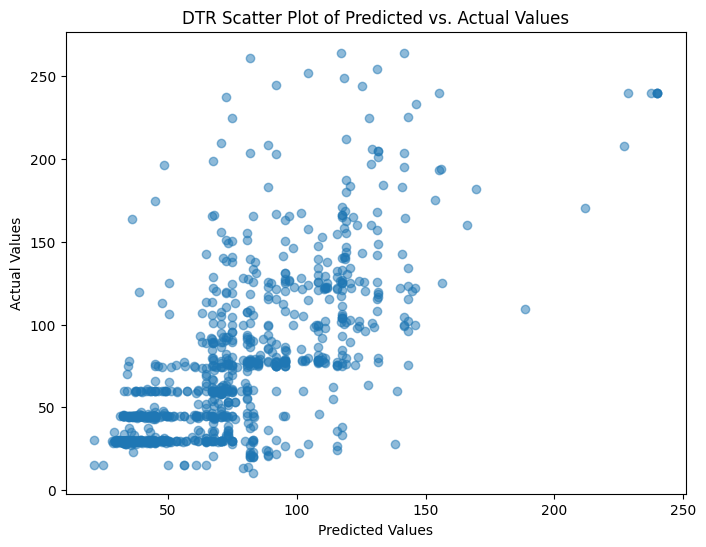

In [ ]:
plot_results(tuned_dtr_predictions, 'DTR')